In [3]:
#modelling USDJPY
import pandas as pd
!pip install numpy pandas
!pip install openpyxl #attribute to install excel reading
%pip install matplotlib seaborn plotly seaborn yfinance statsmodel.api
%pip install scikit-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from pandas import to_datetime
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\Admin\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
ERROR: Invalid requirement: '#attribute'

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\Admin\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement statsmodel.api (from versions: none)
ERROR: No matching distribution found for statsmodel.api

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\Admin\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\Admin\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [4]:

Inflation_diff = pd.read_csv('Inflation_diff.csv')
Interest_diff = pd.read_csv('Interest_diff.csv')
Current_account_diff = pd.read_csv('Current_account_diff.csv')
swaps_df = pd.read_csv('merged_df_month_year.csv')

In [5]:
#3 var linear regression over the 20 years without train_test_split according to timeseries
x_ir = Inflation_diff['USDJPY'].values.reshape(-1, 1)
y_ir = Interest_diff['USDJPY'].values.reshape(-1, 1)
z_ir = Current_account_diff['USDJPY'].values.reshape(-1, 1)
x_ir_3 = np.array(list(zip(x_ir.flatten(), y_ir.flatten(), z_ir.flatten())))
#for the numpy array, column 0 = Inflation, column 1 = Interest, column 2 = Current_account
#renaming the columns

#target variable
Y = swaps_df['USDJPY_20Y'].values.reshape(-1, 1)

model = LinearRegression()
model.fit(x_ir_3, Y)

Y_predict_nosplit = model.predict(x_ir_3)

print(model.score(x_ir_3, Y))

0.5502856644923144


In [6]:
#3 var linear regression over 20 years with train_test_split randomized
x_train, x_test, y_train, y_test = train_test_split(x_ir_3, Y, test_size=0.2, random_state=1)

model = LinearRegression()
model.fit(x_train, y_train)

y_predict_random = model.predict(x_test)

print(model.score(x_train, y_train))
print(model.score(x_test, y_test))




0.5385397758954353
0.5659531108319906


the difference between split and no split is minimal, so we can just train over the twenty year period

In [7]:
#now lets only take values after 2022, which is 48 months of the data
x_ir_3_2yrs = x_ir_3[200:]
Y_2yrs = Y[200:]

model = LinearRegression()
model.fit(x_ir_3_2yrs, Y_2yrs)

Y_predict_2yrs_linear= model.predict(x_ir_3_2yrs)

print(model.score(x_ir_3_2yrs, Y_2yrs))

0.4631652754636527


In [8]:
#polynomial regression over 2 years without train_test_split
poly = PolynomialFeatures(degree=4)
x_poly = poly.fit_transform(x_ir_3_2yrs)

model = LinearRegression()
model.fit(x_poly, Y_2yrs)

Y_predict_2yrs_poly = model.predict(x_poly)

print(model.score(x_poly, Y_2yrs))

0.9230897015487083


we are only going to continue with out 48 months of data

In [9]:
#ridge and lasso regression. To find out whether our dataset is generealizable

In [10]:
ridge_2yr = Ridge(alpha=0.001)
ridge_2yr.fit(x_ir_3_2yrs, Y_2yrs)
Y_predict_ridge_2yr = ridge_2yr.predict(x_ir_3_2yrs)
print(ridge_2yr.score(x_ir_3_2yrs, Y_2yrs))

lasso_2yr = Lasso(alpha=0.001)
lasso_2yr.fit(x_ir_3_2yrs, Y_2yrs)
Y_predict_lasso_2yr = lasso_2yr.predict(x_ir_3_2yrs)
print(lasso_2yr.score(x_ir_3_2yrs, Y_2yrs))

0.46316527523308193
0.4631652114435052


In [11]:
#repeating the same process for the 20year data set for ridge and lasso
ridge_20yr = Ridge(alpha=0.001)
ridge_20yr.fit(x_ir_3, Y)

Y_predict_ridge_20yr = ridge_20yr.predict(x_ir_3)
print(ridge_20yr.score(x_ir_3, Y))

lasso_20yr = Lasso(alpha=0.001)
lasso_20yr.fit(x_ir_3, Y)
Y_predict_lasso_20yr = lasso_20yr.predict(x_ir_3)
print(lasso_20yr.score(x_ir_3, Y))


0.5502806252322381
0.5480745064360926


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.641e+04, tolerance: 8.820e+00
  model = cd_fast.enet_coordinate_descent(


We are getting a better ridg and lasso score for 20years, so lets stick with ridge and lasso

Arima forecasting is a method to forecast timeseries from the belief that past values of a timeseries can alone be used to predict the future values. there ar ethree parameters for the Arima model, the p term, the q term, and the d term. There are some common preprocessing techniques we need to do

1. Data has to be stationary:-
This means the measures of spread of the dataset such as mean, variance and covariance remain unchanged over time

In [12]:
#1. lets test for stationarity at the 5% level
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(Y_predict_ridge_20yr)
print('stat = %.3f, p = %.3f' % adf_test[0:2])

if adf_test[1] > 0.05:
    print("probably not stationary at the 5% level.")
else:
    print("probably stationary at the 5% level.")

stat = -3.134, p = 0.024
probably stationary at the 5% level.


In [13]:
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(Y_predict_ridge_20yr, nlags='auto')
print('stat = %.3f, p = %.3f' % kpss_test[0:2])

if kpss_test[1] > 0.05:
    print("probably stationary at the 5% level.")
else:
    print("probably not stationary at the 5% level.")


stat = 0.435, p = 0.062
probably stationary at the 5% level.


THis indicates our model is infact stationary, lets see this in seasonal decompose

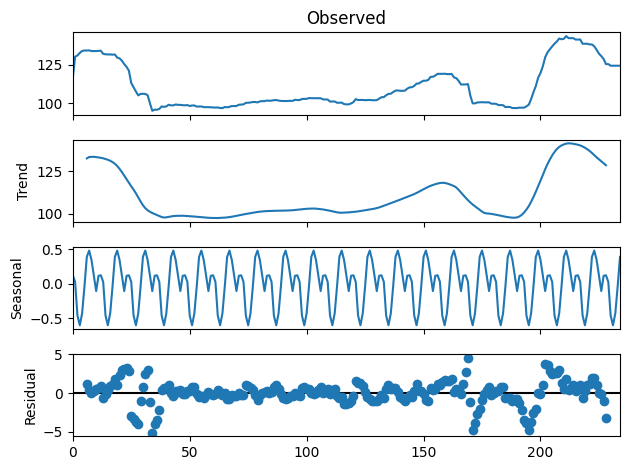

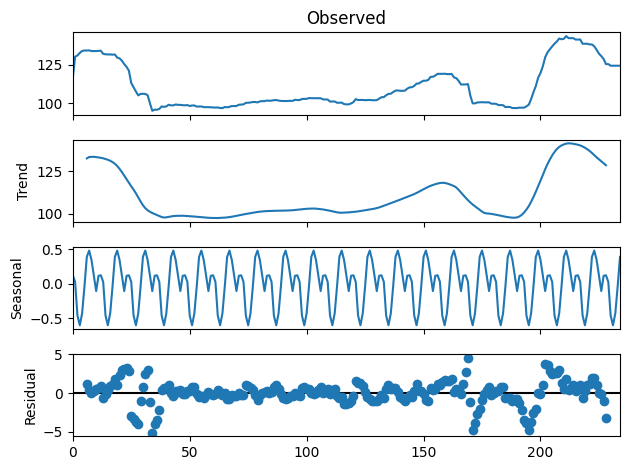

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(Y_predict_ridge_20yr, model='additive', period=12)
result.plot()

The data can be made more stationary, which we will do by log transformating


In [19]:
date = list(range(1, len(Y_predict_ridge_20yr) + 1))

date_fx = pd.DataFrame(zip(date, Y_predict_ridge_20yr), columns=['Date', 'USDJPY'])

date_fx_log = np.log(date_fx['USDJPY'])

date_fx_log_diff = date_fx_log-date_fx_log.shift(1)
date_fx_log_diff[0] = date_fx_log_diff[1]  # Set the first value to 0 to avoid NaN

y_stationary = date_fx_log_diff


In [20]:
#lets see if our stationary has improved
#a. ADF Test
adf_test_2 = adfuller(y_stationary)
print('stat=%.3f, p=%.3f' % adf_test_2[0:2])
if adf_test_2[1] > 0.05:
 print('Probably not Stationary')
else:
 print('Probably Stationary')
#b. KPSS Test
kpss_test_2 = kpss(y_stationary, nlags='auto')
print('stat=%.3f, p=%.3f' % kpss_test_2[0:2])
if kpss_test_2[1] > 0.05:
    print('Probably Stationary')
else:
    print('Probably not Stationary')

stat=-3.349, p=0.013
Probably Stationary
stat=0.069, p=0.100
Probably Stationary


C:\Users\Admin\AppData\Local\Temp\ipykernel_3468\4091760736.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test_2 = kpss(y_stationary, nlags='auto')


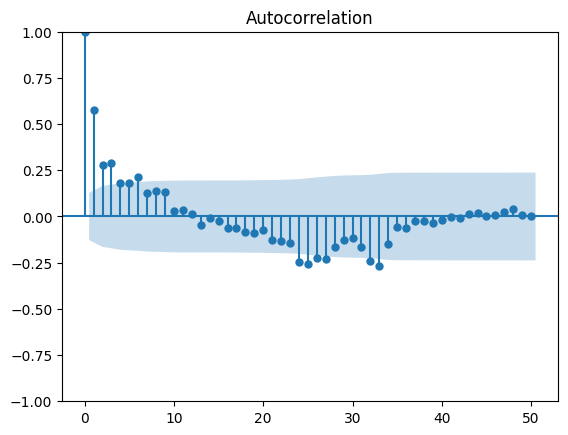

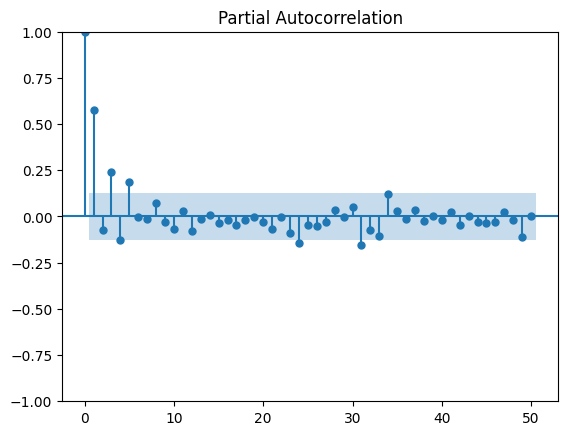

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

date_fx_log_diff = date_fx_log_diff.values.reshape(-1)

plot_acf(date_fx_log_diff, lags=50)
plot_pacf(date_fx_log_diff, lags=50)

plt.show()

In [27]:
#we now have enough info to create the arima model, lets plug in the values
p = 3 #as in 3 significant lags in ACF
d = 1 #as in 1 difference to make it stationary
q = 3 #as in 3 significant lags in PACF
%pip install statsmodels
from statsmodels.tsa.arima.model import ARIMA

y = date_fx_log_diff

model = ARIMA(y, order=(3,1,3))
model_arima_fit = model.fit()

print(model_arima_fit.summary())

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\Admin\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  235
Model:                 ARIMA(3, 1, 3)   Log Likelihood                 693.440
Date:                Mon, 18 Aug 2025   AIC                          -1372.880
Time:                        14:33:27   BIC                          -1348.693
Sample:                             0   HQIC                         -1363.128
                                - 235                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4640      0.166     -2.796      0.005      -0.789      -0.139
ar.L2         -0.1570      0.127     -1.239      0.215      -0.405       0.091
ar.L3          0.5741      0.090      6.400      0.0

In [33]:
# Debugging the loop for finding the best model with the lowest AIC
import itertools

p = range(1, 5)
d = range(1, 2)
q = range(1, 4)

pdq = list(itertools.product(p, d, q))
aics = []
params = []

for param in pdq:
    try:
        model = ARIMA(y, order=param)
        model_arima_fit = model.fit()
        aic = model_arima_fit.aic
        aics.append(aic)
        params.append(param)
    except Exception as e:
        print(f"Error with parameters {param}: {e}")

# Combine AIC values and parameters
combo = list(zip(aics, params))
combo.sort()

# Convert to a pandas DataFrame for better readability
import pandas as pd
combo_df = pd.DataFrame(combo, columns=["AIC", "Parameters"])
print("Best model parameters and AIC values:")
print(combo_df)

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Admin\AppData\Local

Best model parameters and AIC values:
            AIC Parameters
0  -1372.880241  (3, 1, 3)
1  -1371.785964  (4, 1, 3)
2  -1370.449014  (4, 1, 1)
3  -1368.632959  (4, 1, 2)
4  -1366.450026  (1, 1, 2)
5  -1365.370663  (2, 1, 1)
6  -1365.086028  (2, 1, 3)
7  -1364.537102  (2, 1, 2)
8  -1364.495597  (3, 1, 2)
9  -1364.403548  (1, 1, 3)
10 -1363.142546  (3, 1, 1)
11 -1356.642507  (1, 1, 1)


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


the parameter value 3,1,3 is easily the best fit

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


-0.0003346648967703001


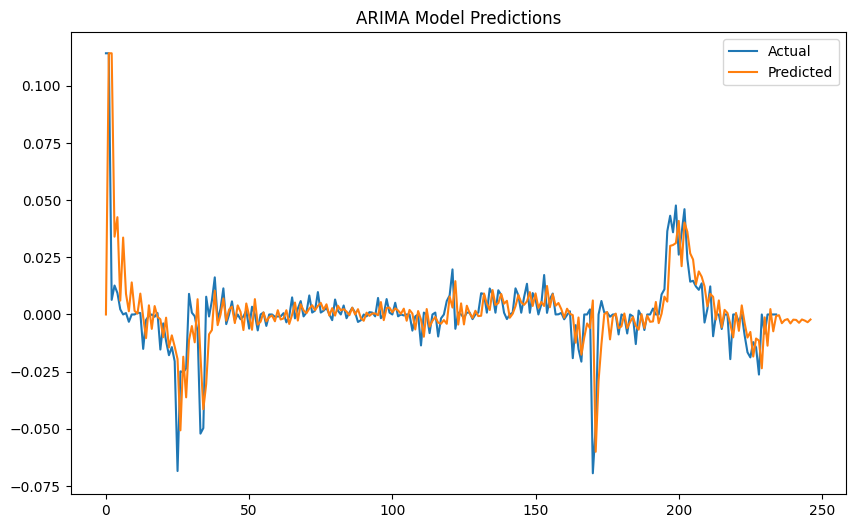

In [49]:
pred = model_arima_fit.forecast(12, alpha = 0.05)[0]

print(pred)

#plotting ARIMA model predictions
plt.figure(figsize=(10, 6))
plt.plot(y, label='Actual')
plt.plot(model_arima_fit.predict(start=0, end=len(y)+11), label='Predicted')
plt.legend()
plt.title('ARIMA Model Predictions')
plt.show()


In [1]:
# Assuming 'pred' contains the forecasted differenced log values
# and 'date_fx_log' contains the original log-transformed values

# Step 1: Reverse differencing
pred_reversed_diff = []
last_log_value = date_fx_log.iloc[-1]  # Get the last log-transformed value from the original data
for value in pred:
    reverted_value = value + last_log_value
    pred_reversed_diff.append(reverted_value)
    last_log_value = reverted_value  # Update the last value for the next iteration

# Step 2: Reverse log transformation
pred_original_scale = np.exp(pred_reversed_diff)

# Print the reverted predictions
print("Predicted USDJPY values on the original scale:")
print(pred_original_scale)

# Plot the reverted predictions
plt.figure(figsize=(10, 6))
plt.plot(range(len(pred_original_scale)), pred_original_scale, label='Forecasted USDJPY')
plt.title('ARIMA Model Forecast on Original Scale')
plt.xlabel('Time Steps')
plt.ylabel('USDJPY')
plt.legend()
plt.show()

NameError: name 'date_fx_log' is not defined